# Streetscapes workspaces

This notebook provides an example of a workflow using Streetscapes. You can load different data sources and ML models, process streetview images and save generated data to your workspace.

This notebook includes the following steps:

- [Define a workspace](#define-a-workspace)
- [Obtaining images](#obtaining-images)
- [Subset data](#2---subset-data)
- [Visualise data](#3---visualise-data)
- [Download images](#4---download-images)
- [Segment images](#5---segment-images)
- [Calculate statistics](#6---calculate-statistics)

### Libraries

In [23]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
import ibis

ibis.options.interactive = True

# --------------------------------------
import geopandas as gpd

# --------------------------------------
import contextily

# --------------------------------------
from PIL import Image

# --------------------------------------
from streetscapes.sources import Mapillary
from streetscapes.models import DinoSAM
from streetscapes.streetview import SVWorkspace

### Define a workspace

Streetscapes has a workspace functionality to facilitate data analysis. Within this workspace, downloaded data, images, segmented masks and analysis for a certain project are self contained and reproducible. 

<span style="color:grey;"><i> Note: You can also pass the path to an `.env` file containing configuration options for the workspace. By default, the workspace looks for an `.env` file inside the workspace directory, and if it doesn't exist, it walks the parent tree until it finds one or it reaches the root of the file system. Environment variables are also recognised automatically.</i></span>

First, create a workspace or load an existing one. In this tutorial, we will be doing an analysis of Amsterdam, so we are naming our workspace "Amsterdam":

In [24]:
ws = SVWorkspace("./Amsterdam")

If we show the contents of the workspace directory, we can see that a subdirectory for Amsterdam was created as well as a [duckdb](https://duckdb.org/) metadata file.

In [25]:
ws.show_contents()

Amsterdam/
├─.gitignore
├─.env
└─metadata.db


Let's now look at where this new workspace is located:

In [26]:
workspace_path = ws.get_workspace_path()
workspace_path

PosixPath('/home/hobbes/code/github/streetscapes/remote/docs/tutorial/Amsterdam')

### Obtaining images

Now let's add which source of images we would like to use. Possible are sources are: [Mapillary](https://www.mapillary.com/), [Kartaview](https://kartaview.org/) and [Amsterdam Open Panorama](https://amsterdam.github.io/projects/open-panorama/). It is also possible to use [Global Streetscapes](https://ual.sg/project/global-streetscapes/) as a data source. 

In this example, we will use Mapillary. 

<span style="color:red;">NOTE</span>: To use Mapillary, you need to have an API token, which you can obtain from the [Mapillary developer portal](https://www.mapillary.com/developer).
Store the token in an `.env` file inside your workspace directory as follows:

```
MAPILLARY_TOKEN=<your-API-token>
```

In [27]:
mp = Mapillary(ws.env)

We can then view where these data sources are located. This will be where all images, instances and masks will be stored. 

In [28]:
mp

Mapillary(root_dir='~/.cache/huggingface/assets/streetscapes/images/mapillary')

Let's have a more detailed look into the data sources that we have loaded. We will find the available images based on a bounding box.

In [29]:
bbox = [4.883466,52.361790,4.916210,52.381494]
df = mp.fetch_image_ids(bbox=bbox)
hdf = df.head(5)
hdf

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┓
┃ id               ┃ altitude  ┃ atomic_scale ┃ camera_type ┃ captured_at   ┃ compass_angle ┃ computed_altitude ┃ computed_compass_angle ┃ computed_geometry                                 ┃ computed_rotation                            ┃ exif_orientation ┃ geometry                                          ┃ height ┃ is_pano ┃ make   ┃ model         ┃ thumb_256_url                                                                    ┃ thumb_1024_url                                                                   ┃ thumb_2048_url                                                                   ┃ thumb_original_url                                                               ┃ sequence               ┃ width ┃ lon      ┃ lat       ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━┩
│ string           │ float64   │ float64      │ string      │ int64         │ float64       │ float64           │ float64                │ struct<coordinates: array<float64>, type: string> │ array<float64>                               │ int64            │ struct<coordinates: array<float64>, type: string> │ int64  │ boolean │ string │ string        │ string                                                                           │ string                                                                           │ string                                                                           │ string                                                                           │ string                 │ int64 │ float64  │ float64   │
├──────────────────┼───────────┼──────────────┼─────────────┼───────────────┼───────────────┼───────────────────┼────────────────────────┼───────────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┼───────────────────────────────────────────────────┼────────┼─────────┼────────┼───────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼────────────────────────┼───────┼──────────┼───────────┤
│ 2172293386289344 │ 50.098000 │     0.802639 │ fisheye     │ 1683741159000 │    348.078913 │          2.665259 │             345.561079 │ {'coordinates': [...], 'type': 'Point'}           │ [1.5538203792879, 0.22772272942943, ... +1]  │                1 │ {'coordinates': [...], 'type': 'Point'

### Visualise Data

Now that we have subsetted the data, we might want to see where the images we want to download are located and if we have good coverage of the city. 

First, the table needs to be converted to a geopandas dataframe and given an appropriate CRS. 

In [30]:
pdf = df.to_pandas()
gdf = gpd.GeoDataFrame(pdf, geometry=gpd.points_from_xy(pdf.lon, pdf.lat))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
gdf.head(5)

,id,altitude,atomic_scale,camera_type,captured_at,compass_angle,computed_altitude,computed_compass_angle,computed_geometry,computed_rotation,...,make,model,thumb_256_url,thumb_1024_url,thumb_2048_url,thumb_original_url,sequence,width,lon,lat
0,2172293386289344,50.098000,0.802639,fisheye,1683741159000,348.078913,2.665259,345.561079,"{'coordinates': [4.8958046296203, 52.371904561...","[1.5538203792879, 0.22772272942943, -0.1673816...",...,GoPro,HERO7 Black,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,hgz5csEuyw4HqBGUC1XZQl,4000,4.895805,52.371905
1,2214473772041985,2.113821,243.100007,perspective,1651584681027,4.766724,1.999902,15.067546,"{'coordinates': [4.890289282911, 52.3653388728...","[1.5653501585152, -0.17028310687785, 0.2428234...",...,Apple,iPhone 13 Pro,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,EXfdPov1FJBupzq02U9IeV,4032,4.890289,52.365339
2,2201783443340884,51.612000,1.035112,fisheye,1687547597000,355.487000,1.194646,343.071082,"{'coordinates': [4.9108905152262, 52.364557475...","[1.5102157453911, 0.26171299179499, -0.1973719...",...,GoPro,HERO7 Black,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,fz4WBbMQTVZ1Gqoe7PdKjX,4000,4.910891,52.364557
3,2199564663716780,49.451000,0.997227,fisheye,1717398810000,39.041000,2.504714,48.565448,"{'coordinates': [4.8889699567427, 52.368443664...","[1.3031780175287, -0.70662946877827, 0.5710038...",...,GoPro,HERO7 Black,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,WHX0bGlqYRSDUtZF13wdON,4000,4.888970,52.368444
4,3269640993308803,70.100000,0.449626,perspective,1657637093000,132.172247,0.114532,132.466114,"{'coordinates': [4.8967783437549, 52.381289687...","[0.93192892253876, -2.0494630200259, 1.4633695...",...,Tesla,none,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/A...,EbVos4devuYFjQGmMPDlA7,1280,4.896778,52.381290


Then we can plot the image locations:

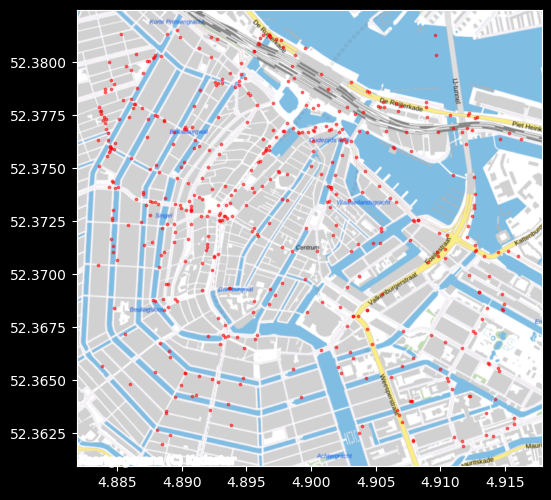

In [31]:
ax = gdf.plot(column='uuid', color='red', markersize=3, figsize=(6, 6), alpha=0.5)
contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.standaard)

### Download images

Let's first download and visualise a single image: 

In [ ]:
image = gdf.iloc[0]
filename = mp.download_image(image.id, image.thumb_1024_url, overwrite=True)
Image.open(filename)

Now let's do this for the first 10 images of our dataset: 

In [ ]:
df_sample = gdf.iloc[:5]
image_ids = df_sample.id
urls = df_sample.thumb_1024_url
paths = mp.download_images(image_ids, urls)

For examples of other data sources, check out the [documentation section](../examples/use_data_sources.ipynb) related to downloading images.

### Segment images

We can load various models and apply them to the image data that we have loaded or generated so far. Currently, Streetscapes supports two segmentation models:

- `MaskFormer`: A relatively small and nimble model that recognises objects from a fixed number of categories.
- `DinoSAM`: A combination of two independent models that work together to perform instance segmentation simply by providing a prompt. It is much more flexible than `MaskFormer` in that it recognises *arbitrary categories*; however, it is much slower.

In this tutorial we will use `DinoSAM`, for a more in-depth tutorial of segmentation with different models, go [here](../examples/segmentation.ipynb). First, we load the model in a similar manner to data sources. Models are spawned globally and can be reused across multiple workspaces to minimise memory consumption for potentially large models.

In [ ]:
model = DinoSAM()

We define the categories of objects that we would like to look for in the images that we are segmenting. Categories are defined hierarchically as a nested dictionary. Subcategories (such as `window` and `door` below) will be identified as separate categories, but the pixels that they occupy will be subtracted from ones attributed to their parent (here, `building`). In this way, it is possible to extract building façades excluding windows and doors. Internally, this nested dictionary is flattened, and any overlaps are handled after instances of the corresponding categories have been identified.

In [ ]:
labels = {
    "building": {
        "window": None,
        "door": None,
    },
    "vegetation": None,
    "car": None,
    "truck": None,
    "road": None,
}

Segment a list of images provided as file paths. Here, we use our subset that we created above. A batch size (defaulting to `1`) can be specified to speed up the segmentation, but here we use a batch size of 1 to show the progress more clearly.

In [ ]:
# TODO: Make this function more flexible so columns names can be set
segmentations = model.segment(paths, labels)
segmentations

The masks and the instances are saved as separate files with the same name as the input image but in different formats (NumPy archived arrays and Parquet files, respectively) so that they can be loaded later together. Here, we print the name of the file containing the mask for the first segmented image.

In [ ]:
segmentation = segmentations[0]
segmentation

In [ ]:
segmentation.get_instance_labels()

Show the distinct categories (out of the ones that we requested) identified by this model.

In [ ]:
segmentation.get_instance_labels(as_table=True).select('label').distinct()

Visualise the parts of the image corresponding to some object categories of interest (here, we ask for everything that is labelled as a `building`).

In [ ]:
segmentation.image_path

In [ ]:
masks = segmentation.get_masks()

In [ ]:
segmentation.visualise(['building', "window"])

If the `visualise()` method is called without an argument, all the identified categories are visualised.

In [ ]:
segmentation.visualise()

We can also extract instances for individual categories and and visualise them in isolation.

In [ ]:
buildings = segmentation.get_instances("building", exclude=["window", "door"])

We will extract the first `building` instance to make working with the instance a bit easier. Here, we also visualise the instance using the built-in `visualise()` method to show the instance in isolation, with the remainder of the image blanked out.

In [ ]:
building = buildings[0]
building.visualise()

We can also visualise a specific channel of the image. Here, we visualise the red channel, which corresponds to index `0`.

In [ ]:
building.visualise(channel=0)

We can also extract a NumPy array representing the pixel values that correspond to the instance by using the built-in `masked()` method. This method also allows us to extract a specific channel. The result can then be used to compute statistics, such as `mean()`.

In [ ]:
masked = building.masked()
masked_red = building.masked(channel=0)

For instance, we can easily compute the 'mean colour' of the instance...

In [ ]:
masked_mean = masked.mean(axis = 0)
masked_mean

...or the mean for a specific channel: 

In [ ]:
masked_red_mean = masked_red.mean(axis=0)
masked_red_mean

We can also perform the same operation on an HSV version of the image by passing `hsv=True` to the `masked()` method:

In [ ]:
masked_hsv = building.masked(hsv=True)
masked_hsv

In [ ]:
masked_v = building.masked(hsv=True, channel=2)
masked_v

A built-in method is provided for convenience to extract the value (brightness) of the instance. It performs the same computation as the cell above.

In [ ]:
brightness = building.brightness()
brightness.mean()

### Calculate statistics

In [ ]:
# Compute albedo (mean V from HSV)
building_means = []
for seg in segmentations:
    buildings = seg.get_instances("building", exclude=["window", "door"], merge = True)
    building_means.append(buildings.brightness().mean())

In [ ]:
building_means

In [ ]:
# TODO:
# instance.get_material()

# TODO:
# Add statistics to metadata

# TODO:
# Add model parameters to the segmentation metadata for each image (parquet file)